# QRAM

The goal of QRAM is to extract states that are stored in the Memory cells. It extracts whatever is stored in the memory cells and routes them onto the bus qubits which are the output of the QRAM. Bucket Brigade Quantum RAM can hold only classical information but it can query a superposition of all these. The overall process can be written as , 
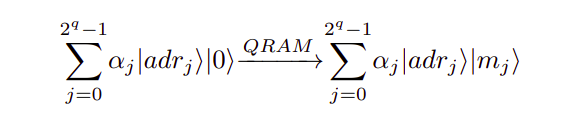
where $|adr_i>$ is the address of the memory cell and the $|m_i>$ is the classical bit stored in that memory cell.


We will be using this output as the input states to our Rotation circuit which will rotate all the vectors using Quantum Superposition. The final points can be identified on the basis of the pointer states which will actually be the address qubits. 

#### Some Papers summary 

Bucket Brigade QRAM was introduced in [1] for storing and accessing information in Quantum Computers. [2] gives us the circuit that has been made in this circuit, this can also be seen in this blog[6]. Furthermore [3] goes into how we can use clifford + T gates in order to make this more effecient(not necessary) and [5] is a study which compares implementation of various models of QRAM. [4] proposes a totally different model but this particular model is not implementable on the circuit approach. 

In [136]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

Our QRAM circuit takes in no. of address qubits, no. of qubits that are present in each memory cell and what quantum state do we want to be stored in the Memory cell. This can be easily used to store classical information and query them using the superposition state that we want.  

**Note -** The data vector should have $2^a$ elements each of which should be smaller than $2^{mc}$.

In [152]:
def QRAM(no_of_address_qubits,no_of_bits_in_memory_cell, data):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc # no. of classical readout bits if we are only looking at the bus 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_yesa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    

    ## adding the state that will be qureied out and the memory can be stored here
    qc = qc.compose(input_add(a, mc))
    qc = qc.compose(mem_data(a, mc, data))
    
    
    ### here we will start with the branching
    # there is X gate at the second qubit first
    qc.barrier()
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    qc.barrier()
    
    # further branchings 
    if mc==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                 qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                 qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM(a,mc))


    
    ## finally measuring the bus
    for i in range(0,a):
        qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus[i], cr[a+i])
    qc.measure(qr_bus[1],cr[2])
    return qc

## Meas QRAM 

As the decoder part of the circuit activates different encoding qubits on the basis of different values that we provide. We have to make sure that the correct boolean value is corresponded to the correct value of the memory cell. For eg. on inputting |10> we should get memory cell 2.

**Ordering** - One thing that is rather very important is the fact the ordering.  The top most qubit($q_0$) comes on the lesftmost position we were putting these in the left most position. But cosidering QISKIT's ordering is different we will be switching this ordering. 

In [148]:
def meas_QRAM(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_yesa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
### measruing the correct qubit is the main things
    ## here we will make the array which has the ability to couple to the correct qubit it goes like(this is the 
    ## opposite convention of qiskit, qiskit does |q2q1q0> but this basis on q0q1q2)
    ##  1          10         100
    ##  0          00         000
    ##             11         110
    ##             01         010
    ##                        101 .... so on basically half the qubits gets concatinated with 0 and other half with 1

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job



    ## the ordering in which we measure will be same just that it will have to be repeated a couole of times
    ## 1,0,3,2 to 1,1,0,0,3,3,2,2 for case of two 
    final_ord_mat = np.zeros([mc,len(div_decimal)])
    for i in range(len(div_decimal)):
        add = 0
        for j in range(mc):
            final_ord_mat[j,i] = int(div_decimal[i])*int(mc)
            final_ord_mat[j,i] += add
            add = add + 1
    ## now this matrix has to be concatinated onto one another
    final_ord = np.reshape(final_ord_mat,(int(final_ord_mat.size),1), order='F')
    
    
    
    ## now we will also need to input address orderings 
    add_ord = np.zeros(mc*len(div_decimal))
    j_last = 0    
    for i in range(0, len(div_decimal)):
         # the purpose of j_last is is to start from where the last loop stopped in i+j terms
        for j in range( j_last, j_last + mc):
            add_ord[i+j] = i
            j_last = j
            
    ## this one is here for bus orderings 
    bus_ord = np.zeros(0)
    one_ord = range(0, mc)
    for i in range(0,r):
        bus_ord = np.append(bus_ord,one_ord)
            

            
    ## finally adding the ccx gates which will copy out whatever is in the memory cells to the Bus
    for i in range(0, m ):
        qc.ccx(qr_r[int(add_ord[i])], qr_m[int(final_ord[i])], qr_bus[int(bus_ord[i])])
        
        
### you can adjust th

    
    return qc


In [139]:
def meas_QRAM_order(no_of_address_qubits):
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = 2**a # no. of memory qubits
    bus = 1+a # no. of bus qubits 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(1, "bus")
    cr = ClassicalRegister(bus, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
### measruing the correct qubit is the main things
    ## here we will make the array which has the ability to couple to the correct qubit it goes like(this is the 
    ## opposite convention of qiskit, qiskit does |q2q1q0> but this basis on q0q1q2)
    ##  1          10         100
    ##  0          00         000
    ##             11         110
    ##             01         010
    ##                        101 .... so on basically half the qubits gets concatinated with 0 and other half with 1

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job

    for i in range(0, 2**a  ):
        qc.ccx(qr_r[i], qr_m[int(div_decimal[i])], qr_bus)
        
        
### you can adjust th

    
    return qc

This will be used in order to initialise what we have in QRAM and which memory locations do we want to query out 

In [140]:
def input_add(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_yesa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    ## you can make the superposition here to query the QRAM 
    
    qc.h(qr_a[0])
    #qc.h(qr_a[1])
    

    
    # adding a barrier at the end 
    qc.barrier()
    
    return qc

These are subroutines which are used for realising the pattern

In [141]:
## to functions that we will be using for concatination of "0" and "1" in front the numbers and the other one for addition for the conversion of the binary to decimal 
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

## for convertign from decimal to binary 
def decimalToBinary(n,no_of_places):
    num = no_of_places ## this will be equal to mc
    binary = bin(n).replace("0b", "")
    if (len(binary) != num):
        i = num - len(binary)
        for j in range(0,i):
            binary = numConcat(0,binary)

    return binary

### Inputting memory cells

This function will be directly be able to create a quantum circuit which will actually tell us what is stored in the memory cells. 

In [142]:
def mem_data(no_of_address_qubits,no_of_bits_in_memory_cell, data):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_yesa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    ## each of data points should be smaller than 2**mc
    
    for i in range(0,len(data)):
        if data[i]>2**mc:
            print("Error!! The value of the data to be stored is bigger then the 2**mc")
            return
    
    bin_data = ["" for x in range(len(data))]
    ## the data needs to convert to binary from decimal
    for i in range(0,len(data)):
        bin_data[i] = decimalToBinary(data[i], mc)
        
    
    new_data = np.zeros([len(data), mc])
    
    # now we will be dividing all our divided
    for i in range(len(data)):
        for j in range(mc):
            new_data[i, j] = bin_data[i][j]
    
    ## fliping the matrix around so the ordering is proper according QISKIT
    flip_new_data = np.flip(new_data,1)
    ## this will be arranged in a row vector so that we can run a loop over it 
    new_data_row = np.reshape(flip_new_data,[1,mc*len(data)])
    
    for i in range(len(new_data_row[0])):
        if new_data_row[0,i] == 1:
            qc.x(qr_m[i])
            
    return qc

In [143]:
mem_data(2,3,[5,7,0,3]).draw()

a_0: ─────
                
      a_1: ─────
                
      r_0: ─────
                
      r_1: ─────
                
      r_2: ─────
                
      r_3: ─────
           ┌───┐
      m_0: ┤ X ├
           └───┘
      m_1: ─────
           ┌───┐
      m_2: ┤ X ├
           ├───┤
      m_3: ┤ X ├
           ├───┤
      m_4: ┤ X ├
           ├───┤
      m_5: ┤ X ├
           └───┘
      m_6: ─────
                
      m_7: ─────
                
      m_8: ─────
           ┌───┐
      m_9: ┤ X ├
           ├───┤
     m_10: ┤ X ├
           └───┘
     m_11: ─────
                
    bus_0: ─────
                
    bus_1: ─────
                
    bus_2: ─────
                
readout: 5/═════

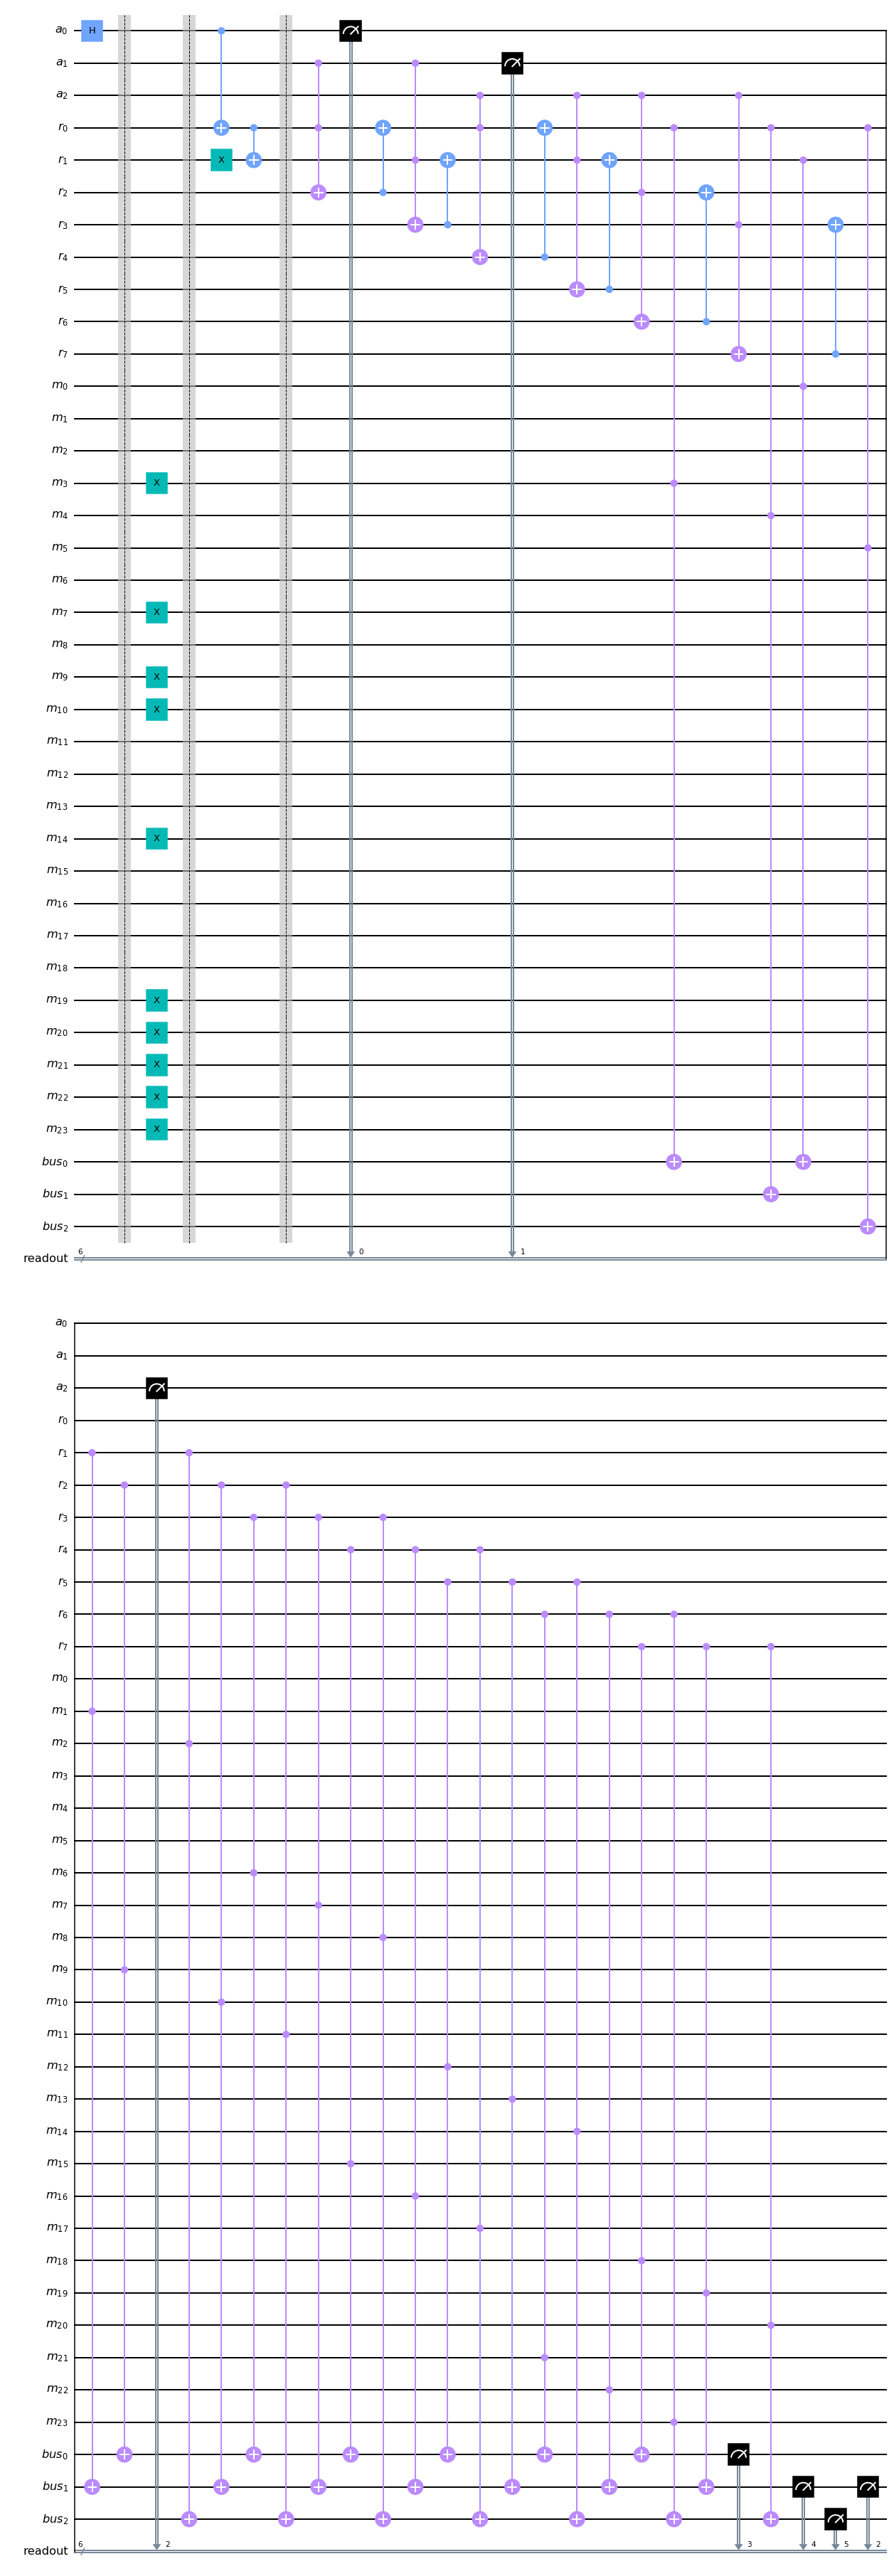

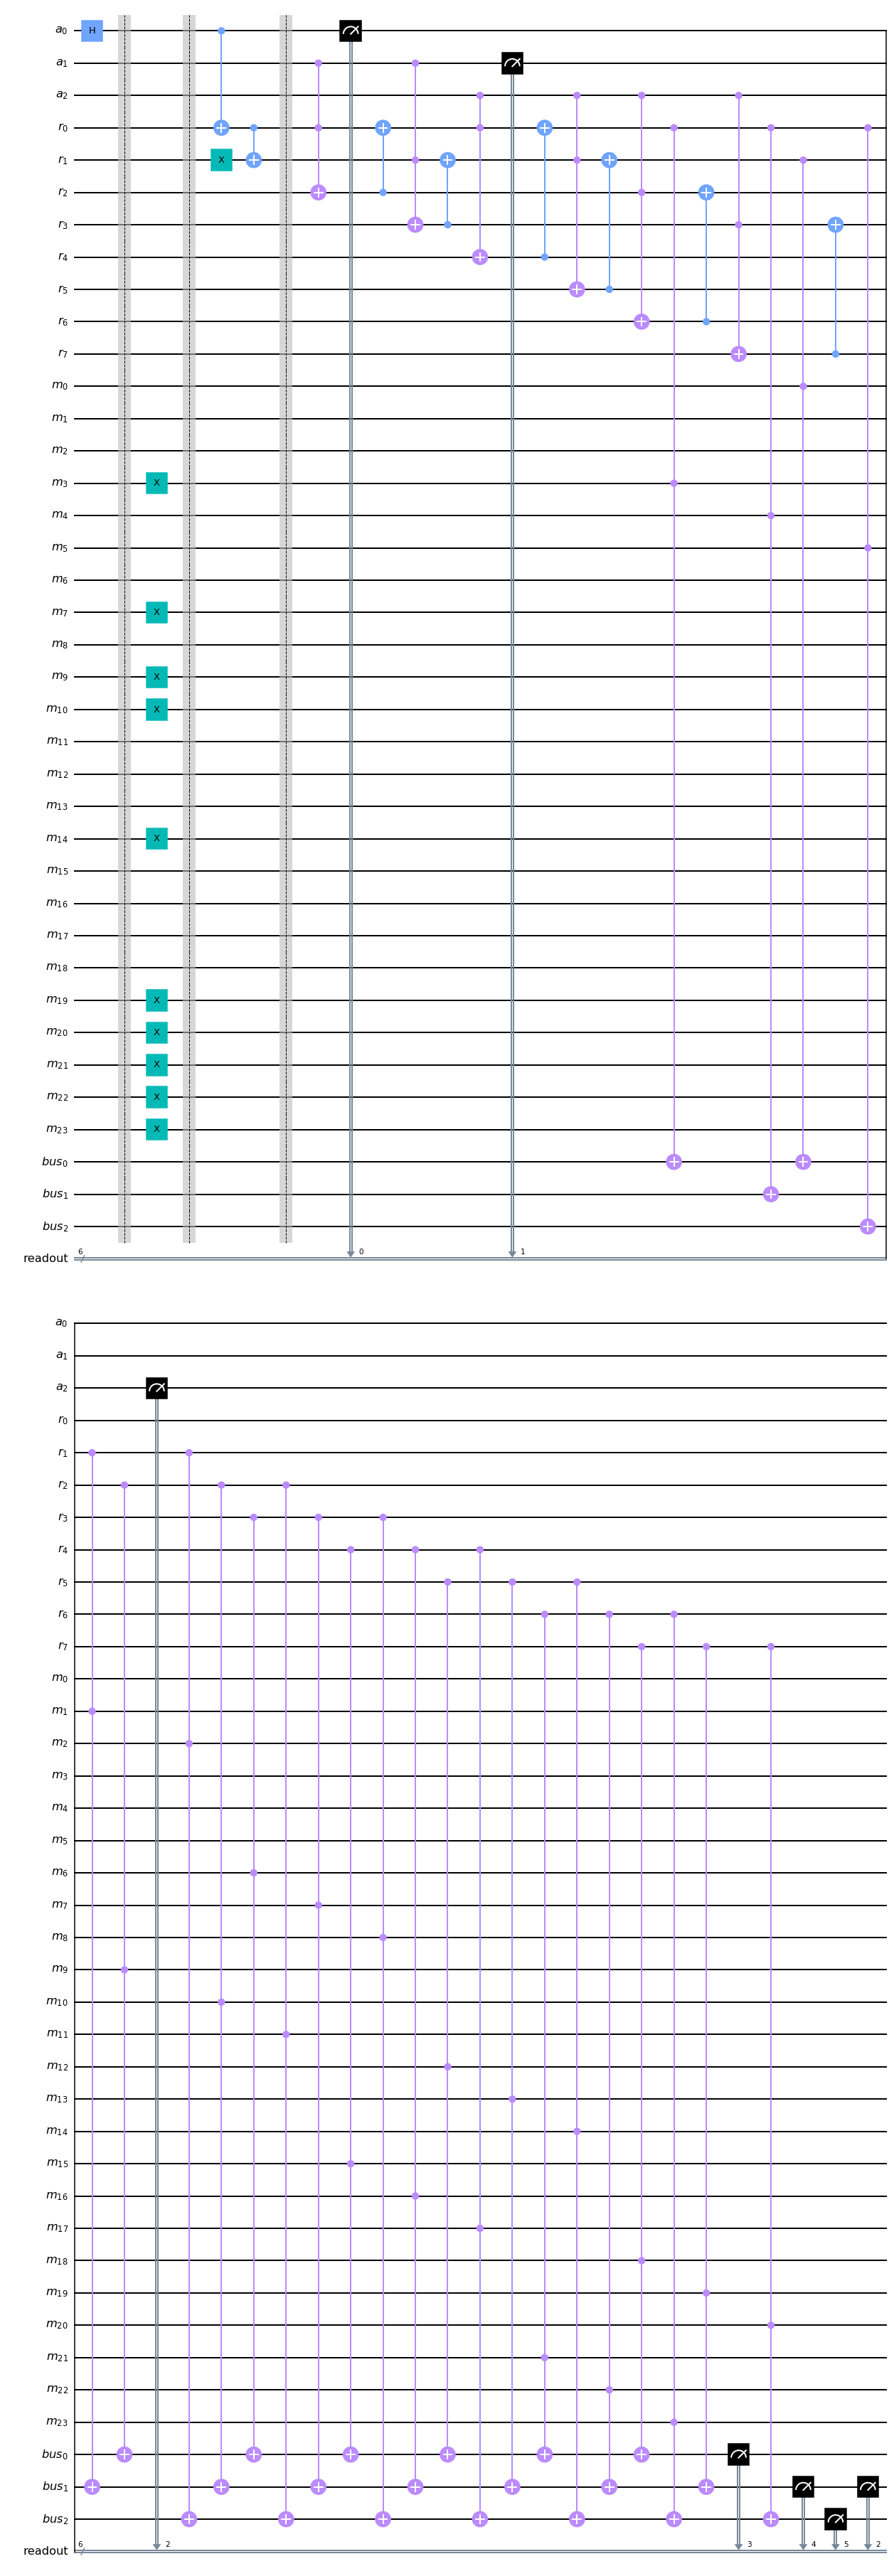

In [153]:
QRAM(3,3,[0,1,2,3,4,0,6,7]).draw('mpl')

#### Step by step analysis 
Here we will be inputting the state ${|\psi>}$into QRAM(1,1)

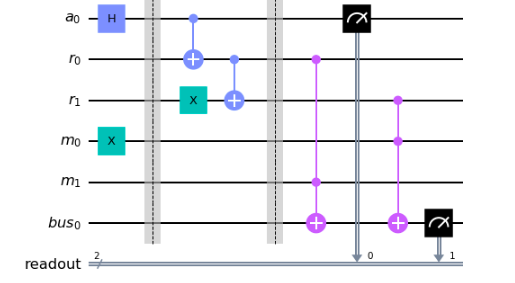

The state looks like
$$
|\psi> = |0> + |1>
$$

and this should look into the memory cells 0 and 1 and as we have stored '0' in memory cell 1 and '1' in memory cell 0. The final state, 
$$
|\phi> = |1>|0> + |0>|1>
$$
**Note** here the ordering is |memory>|adress> because of the ordering of qiskit and for later discussion the qubits are ordered as **$|bus_0 m_1 m_0 r_1 r_0 a_0>$**

After first hadamard gate, we get

$$
|0> + |1>
$$

cx between r_0 and a_0

$$
|00> + |11>
$$

the r_1 bit will flip if the r_0 is on 

$$
|100> + |011>
$$

now the memory bits are introducd and these are stuck and will not change

$$
|01100> + |01011>
$$

two ccx gates determine finally which qubit line is measured, first one is r_0 and m_1

$$
|(0)11(0)0> + |(0)10(1)1>
$$

and this copies whatever is there in m1 to bus

$$
|001100> + |0101011>
$$

Second one does a similar thing and we see that, r_1 and m_0 matters 

$$
|00(11)00> + |010(10)11>
$$

we get 

$$
|101100> + |0101011>
$$

now ignoring all the middle ones and focusing on $|bus_0 0 0 0 0 a_0>$. We get, 

$$
|10> + |01>
$$

That is what we should get.

## Testing 

We will be testing our QRAM here by trying out a few examples. 


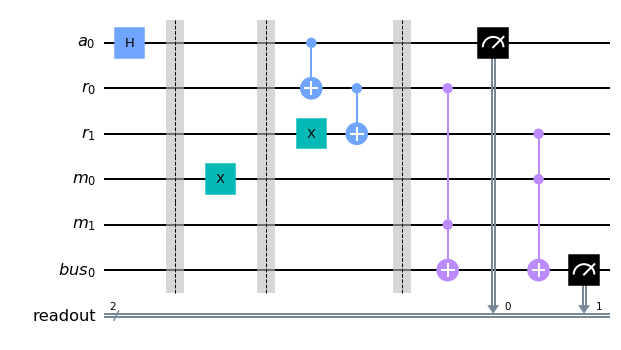

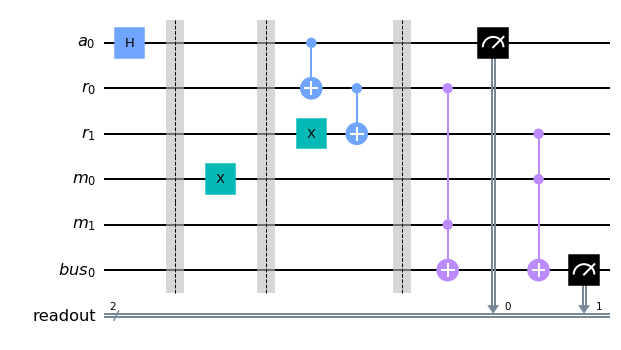

In [154]:
qc_1 = QRAM(1,1,[1,0])
qc_1.draw('mpl')

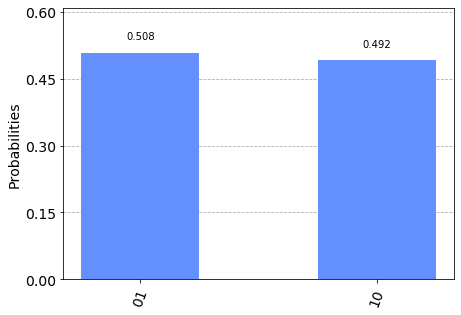

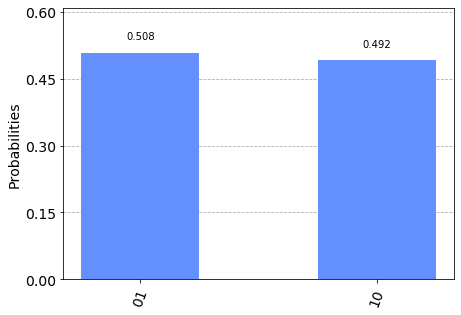

In [155]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc_1,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### Testing 2 

Let's try storing |01> and |00> both of which represent possible vectors in the 3d space. We will be storing |00> in 1 st memory cell and |01> in 0 th one. The final output should be 
$$
|00>|1> + |01>|0>
$$

We only need two memory cells(so a = 1) and two qubits per memory cells so (mc = 2)

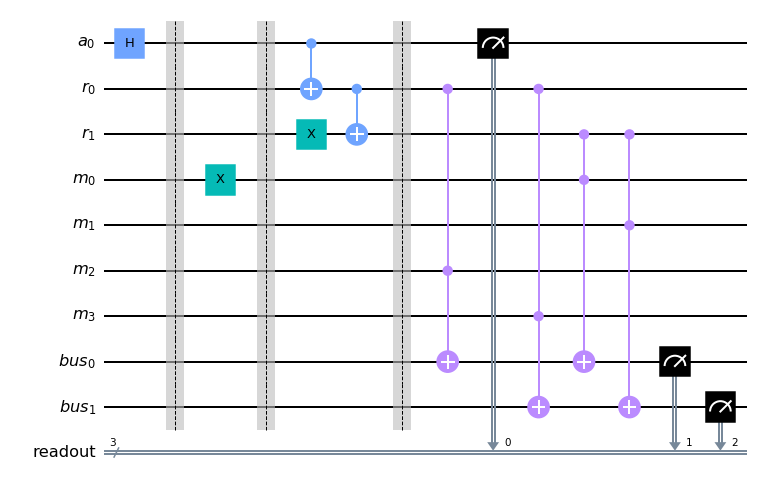

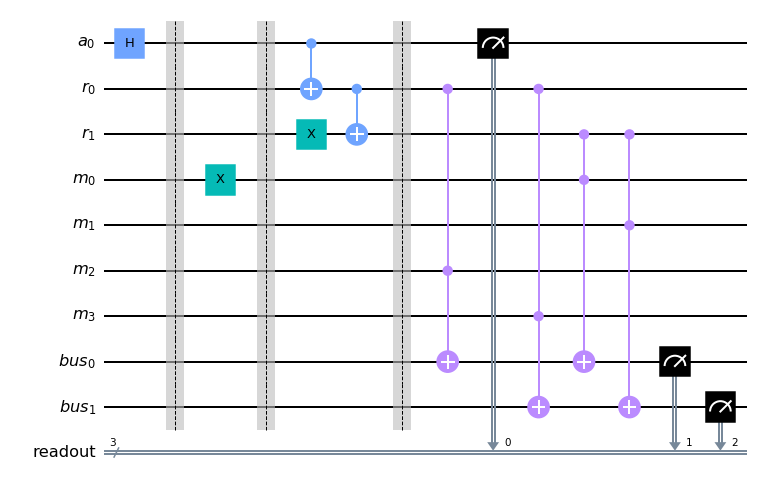

In [156]:
qc_2 = QRAM(1,2,[1,0])
qc_2.draw('mpl')

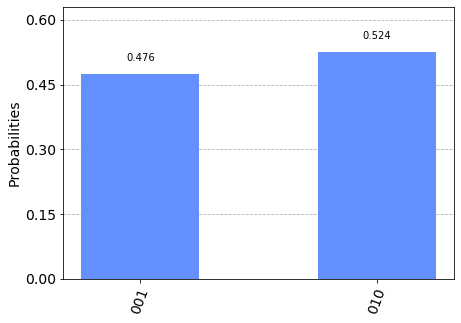

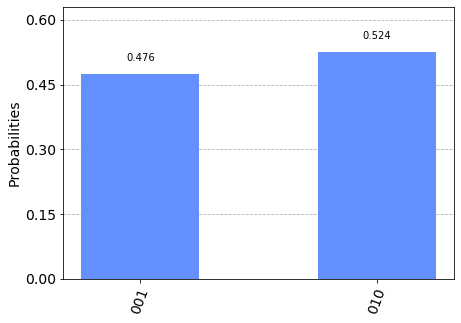

In [157]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc_2,backend)
counts = job.result().get_counts()
plot_histogram(counts)

Hence we can see that this model works 

## Refrences 
1. [Quantum random access memory](https://arxiv.org/abs/0708.1879)
2. [On the robustness of bucket brigade quantum RAM](https://arxiv.org/abs/1502.03450)
3. [Parallelising the Queries in Bucket Brigade Quantum RAM](https://arxiv.org/abs/2002.09340)
4. [Quantum random access memory via quantum walk](https://iopscience.iop.org/article/10.1088/2058-9565/abf484)
5. [Fault-Tolerant Resource Estimation of Quantum Random-Access Memories](https://ieeexplore.ieee.org/document/8962352)
6. [IMPLEMENTING QRAM IN QISKIT WITH CODE(a blogpost)](https://quantumcomputinguk.org/tutorials/implementing-qram-in-qiskit-with-code)
